# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data
training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.
import numpy as np
assert(len(X_train) == len(y_train))
assert(len(X_test) == len(y_test))
# TODO: Number of training examples
n_train = len(y_train)

# TODO: Number of testing examples.
n_test = len(y_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_labels = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_labels)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

All possible sign labels


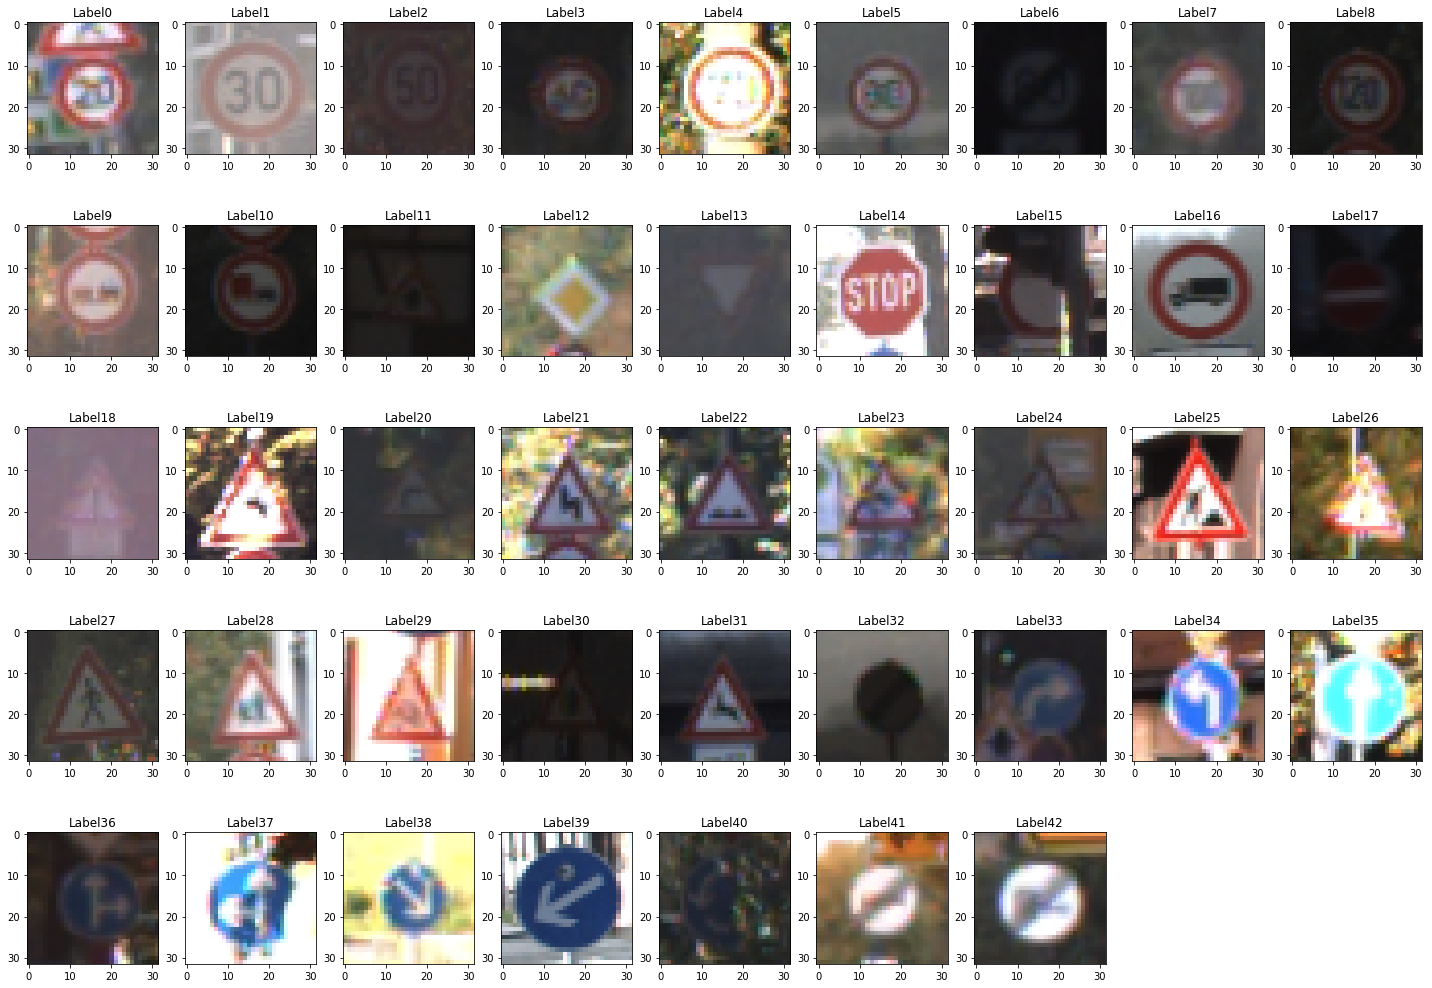

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import random
import math
import cv2
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

def plot_images(images, label, n_cols=9):
    n_rows = math.ceil(n_labels/n_cols)
 
    plt.figure(figsize=(n_rows*5, n_cols*2))   
    for i,image in enumerate(images):
        image = image.squeeze()
        plt.subplot(n_rows, n_cols, i+1)  
        plt.title("Label" + str(i))
        plt.imshow(image)
    plt.show()

# get all unique images
unique, unique_idx, unique_counts = np.unique(y_train, return_index=True, return_counts=True)
print("All possible sign labels")
plot_images(X_train[unique_idx], y_train[unique_idx])

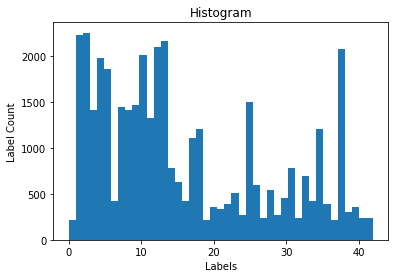

In [4]:
# Exploration of the label distribution
def plot_histogram(labels, n_labels):
    plt.hist(labels, n_labels)
    plt.xlabel('Labels')
    plt.ylabel('Label Count')
    plt.title('Histogram')
    plt.show()
plot_histogram(y_train, n_labels)    

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [5]:
### Preprocess the data here.
# Implement Min-Max scaling for color image data
def normalize_color(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = 0.1
    b = 0.9
    color_min = 0
    color_max = 255
    return a + ( ( (image_data - color_min)*(b - a) )/( color_max - color_min ) )

X_train = normalize_color(X_train)  
### Feel free to use as many code cells as needed.

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**
I preprocessed the images by Min-Max scaling to a range of 0.1-0.9. The values of the Standard Deviation are small and should improve Backpropagation. I also tried zero mean scaling but at least with my approach there was no improvement.

Another approach could be to convert the images to grayscale to reduce the data but this might have a disadvantage when some signs mainly differ in color.

Shifted image example


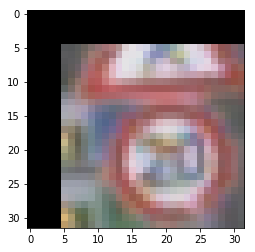

Rotated image example


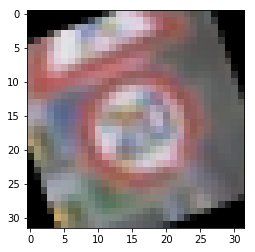

Scaled image example


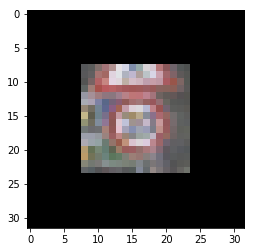

Blured image example


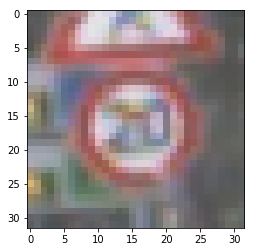

Sharpened image example


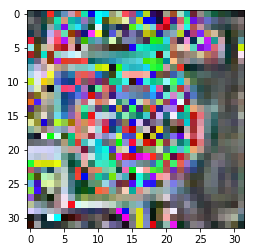

In [6]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import cv2

# Using opencv functions to make Geometric Transformations
# http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html
def translate(image, tx=0, ty=0):
    '''
    Translate/Shift an image by (tx, ty) 
    '''
    # Translation matrix
    M = np.float32([[1,0,tx],[0,1,ty]])    
    return cv2.warpAffine(image,M,image.shape[0:2])

def rotate(image, angle=0):
    '''
    Rotate image by angle in degrees
    '''
    rows,cols = image.shape[0:2]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),angle,1)
    return cv2.warpAffine(image,M,image.shape[0:2])

def scale(image, factor=1.0):
    '''
    Scale image by factor
    '''
    rows,cols = image.shape[0:2]
    M = cv2.getRotationMatrix2D((cols/2,rows/2),0,factor)    
    return cv2.warpAffine(image,M,image.shape[0:2])

def brighten(image, factor=1.0):
    '''
    Change brightness of image by factor
    '''
    image = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    image[:,:,2] = image[:,:,2] * factor
    return cv2.cvtColor(image,cv2.COLOR_HSV2RGB)

def blur(image, kernel=5):
    '''
    
    '''
    return cv2.medianBlur(image,kernel)
    
def sharpen(image):
    '''
    
    '''
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    return cv2.filter2D(image, -1, kernel)

print("Shifted image example")
plt.imshow(translate(X_train[0],5,5))
plt.show()

print("Rotated image example")
plt.imshow(rotate(X_train[0],20))
plt.show()

print("Scaled image example")
plt.imshow(scale(X_train[0],0.5))
plt.show()

# print("Brightened image example")
# plt.imshow(brighten(X_train[0],0.5))
# plt.show()

print("Blured image example")
plt.imshow(blur(X_train[0], 1))
plt.show()

print("Sharpened image example")
plt.imshow(sharpen(X_train[0]))
plt.show()

New training set shape= (167276, 32, 32, 3)


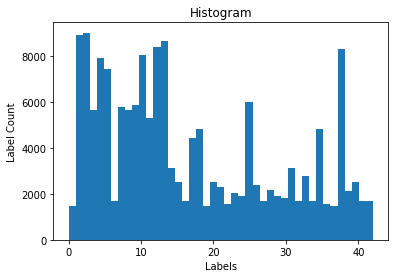

In [7]:
def generate_random_images(X,y):
    """
    Generate augmented images randomly
    """
    unique, unique_idx, unique_counts = np.unique(y, return_index=True, return_counts=True)
    max_count = np.max(unique_counts)

    for image, label in zip(X,y):        
        n_to_generate = int(max_count/unique_counts[label])
        for i in range(0,n_to_generate,5):
            image_aug = (translate(image, np.random.uniform(-5,5),np.random.uniform(-5,5)))
            yield image_aug,label 
            image_aug = (rotate(image,np.random.uniform(-10,10)))
            yield image_aug,label 
            image_aug = (scale(image,np.random.uniform(0.8,1.2)))
            yield image_aug,label   

X_aug =[]
y_aug = []
for image, label in generate_random_images(X_train,y_train):
    X_aug.append(image)
    y_aug.append(label)
X_train = np.concatenate((X_train, X_aug))
y_train = np.concatenate((y_train, y_aug))

assert(len(X_train) == len(y_train))
del X_aug
del y_aug
print("New training set shape=", X_train.shape)

plot_histogram(y_train, n_labels)

In [8]:
# there is no validation set -> create validation set from training set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=random.randint(0,100000))
X_train, y_train = shuffle(X_train, y_train)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

_Augmented Data_: 

I generated additional data by translation, rotating and scaling the training set. I also tried brightening, sharpening and bluring image but the overall dataset  got too big and I ran out of memory. More data and modified data should improve generalisation of the model. If you compare the old and the new distribution I generated more of the less occured sign images to let the algorithm learn them good enough, but overall I didn't want t destroy the complete distribution because this may reflect the real distribution.

_Training, Validation, Testing_: 

The test data was already available in the "test.p" file and I didn't touch it till the end. After augmentation of the training data in "train.p" file I splitted it into 80% training and 20% validation data.

In [9]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf

EPOCHS = 50
BATCH_SIZE = 128

from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    n_labels = 43 
    c1_depth = 6
    c2_depth = 16
    
    weights = {
        'wc1': tf.Variable(tf.truncated_normal([5, 5, 3, c1_depth], mean=mu, stddev=sigma)),
        #'wc1': tf.get_variable("wc1", shape=[5, 5, 3, 6], initializer=tf.contrib.layers.xavier_initializer()),
        'wc2': tf.Variable(tf.truncated_normal([5, 5, c1_depth, c2_depth], mean=mu, stddev=sigma)),
        #'wc2': tf.get_variable("wc2", shape=[5, 5, 6, 16], initializer=tf.contrib.layers.xavier_initializer()),
        'wd1': tf.Variable(tf.truncated_normal([5*5*c2_depth, 120], mean=mu, stddev=sigma)),
        'wd2': tf.Variable(tf.truncated_normal([120, 84], mean=mu, stddev=sigma)),
        'out': tf.Variable(tf.truncated_normal([84, n_labels], mean=mu, stddev=sigma))}
    
    biases = {
        'bc1': tf.Variable(tf.zeros(c1_depth)),
        'bc2': tf.Variable(tf.zeros(c2_depth)),
        'bd1': tf.Variable(tf.zeros(120)),
        'bd2': tf.Variable(tf.zeros(84)),
        'out': tf.Variable(tf.zeros(n_labels))}
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    x = tf.nn.conv2d(x, weights['wc1'], strides=[1,1,1,1], padding='VALID')
    x = tf.nn.bias_add(x, biases['bc1'])   

    # Activation.
    x = tf.nn.relu(x)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')
    
    # Layer 2: Convolutional. Output = 10x10x16.
    x = tf.nn.conv2d(x, weights['wc2'], strides=[1,1,1,1], padding='VALID')
    x = tf.nn.bias_add(x, biases['bc2'])
    
    # Activation.
    x = tf.nn.relu(x)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    x = tf.contrib.layers.flatten(x)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    x = tf.add(tf.matmul(x, weights['wd1']), biases['bd1'])
    
    # Activation.
    x = tf.nn.relu(x)
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)    

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    x = tf.add(tf.matmul(x, weights['wd2']), biases['bd2'])
    
    # Activation.
    x = tf.nn.relu(x)
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)     

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    logits = tf.add(tf.matmul(x, weights['out']), biases['out'])
    
    return logits

In [10]:
# `x` is a placeholder for a batch of input images.
# `y` is a placeholder for a batch of output labels.
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
# probability for dropout layers, should be 1.0 for evaluation/test
keep_prob = tf.placeholder(tf.float32)

one_hot_y = tf.one_hot(y, n_labels)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

_Model_:

Right now I have no GPU available therefore I sticked with the LeNet5 architecture out of performance reason. Similar to the picture below just with 43 outputs. I tried to increase the layer depth but this just took too much computational time without much improvement:
![title](lenet5.png)
LeNet. Source: Yann Lecun.

_Layers_:

Input: 32x32x3 image

Convolution layer 1. The output shape should be 28x28x6.

ReLu Activation

Pooling layer 1. The output shape should be 14x14x6.

Convolution layer 2. The output shape should be 10x10x16.

ReLu Activation

Pooling layer 2. The output shape should be 5x5x16.

Flatten layer. Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. This should have 400 outputs.

Fully connected layer 1. This should have 120 outputs.

Activation 3. Your choice of activation function.

Dropout 1. 50% Dropout

Fully connected layer 2. This should have 84 outputs.

Activation 4. Your choice of activation function.

Dropout 2. 50% Dropout

Fully connected layer 3. This should have 43 outputs.


In [11]:
### Train your model here.
### Feel free to use as many code cells as needed.
rate = 0.001

logits = LeNet(x)
prob = tf.nn.softmax(logits)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [12]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples



In [13]:
train_acc_epoch = []
valid_acc_epoch = []
train_loss_epoch = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            _, loss = sess.run([training_operation, loss_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
        
        train_accuracy = evaluate(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)        
        print("EPOCH {} ...".format(i+1))
        print("Loss = {:.3f}".format(loss))
        print("Train Accuracy = {:.3f}".format(train_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        train_loss_epoch.append(loss)
        train_acc_epoch.append(train_accuracy)
        valid_acc_epoch.append(validation_accuracy)
        
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Loss = 1.440
Train Accuracy = 0.639
Validation Accuracy = 0.635

EPOCH 2 ...
Loss = 1.371
Train Accuracy = 0.774
Validation Accuracy = 0.771

EPOCH 3 ...
Loss = 0.839
Train Accuracy = 0.833
Validation Accuracy = 0.830

EPOCH 4 ...
Loss = 0.739
Train Accuracy = 0.859
Validation Accuracy = 0.855

EPOCH 5 ...
Loss = 0.571
Train Accuracy = 0.878
Validation Accuracy = 0.873

EPOCH 6 ...
Loss = 0.842
Train Accuracy = 0.890
Validation Accuracy = 0.883

EPOCH 7 ...
Loss = 0.797
Train Accuracy = 0.905
Validation Accuracy = 0.898

EPOCH 8 ...
Loss = 0.528
Train Accuracy = 0.906
Validation Accuracy = 0.901

EPOCH 9 ...
Loss = 0.560
Train Accuracy = 0.916
Validation Accuracy = 0.908

EPOCH 10 ...
Loss = 0.558
Train Accuracy = 0.923
Validation Accuracy = 0.915

EPOCH 11 ...
Loss = 0.585
Train Accuracy = 0.926
Validation Accuracy = 0.916

EPOCH 12 ...
Loss = 0.395
Train Accuracy = 0.933
Validation Accuracy = 0.924

EPOCH 13 ...
Loss = 0.309
Train Accuracy = 0.936
Validation 

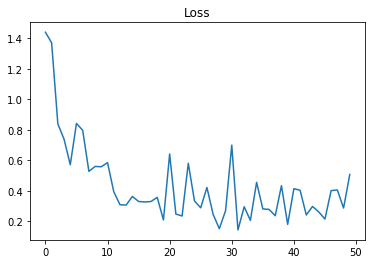

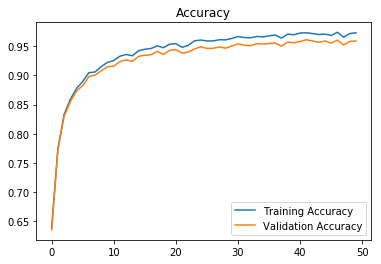

In [14]:
# plot the Loss and Accuracy
plt.title('Loss')
plt.plot(train_loss_epoch, label='Training Loss')
plt.show()

plt.title('Accuracy')
plt.plot(train_acc_epoch, label='Training Accuracy')
plt.plot(valid_acc_epoch, label='Validation Accuracy')
plt.legend(loc=4)
plt.show()

In [15]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.933


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

_Batch Size_: 128, power of 2 this should be memory efficient and bigger batch size was not possible due memory issues.

_Epochs_: 100, there is not much improvement above

_Optimizer_: Adam, converges faster than the normal Gradient descent

_Learning Rate_: 0.0008, the accurracy values are reasonable with this starting learning rate and the Adam Optimizer changes it
during training

_Dropout Probability_: 0.5, to avoid overfitting

_Weight Initialization_: Zero mean, 0.1 STD, break symetry and should work fine with small networks. For bigger networks Xavier Initializer is a better option.

Overall the Test Accuracy ist 93.3%. Which is quite OK for a LeNet model but not comparable with the big models.


### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
I started with the LeNet-5 Network from the lab and modified it to color images and an output of 43 classes. It was already performing pretty good on the training and validation set but only 87% on the test set. A clear indicator for overfitting therefore I added two dropout layers after the fully connected layers. The accuracy of training/validation decreased but the accuracy of testing improved. 

Then I tried to deepen the conv layers but I did not see huge difference there. It was just way slower. So far I have no GPU to use so I also considered to use grayscaled images to get better computational performance and although it might be reasonable to use grayscale for the provided dataset I know that there are some German traffic signs which mainly differ in color. Recently I read about SqueezeNet and I will try this next.

Adding Data augmentation was a big step. Interesting was that applying all augmentation methods on the same image gave worse accuray but further steps here would probably have a huge effect.


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

New images in original size, The originator of these images is Halteverbot123.de


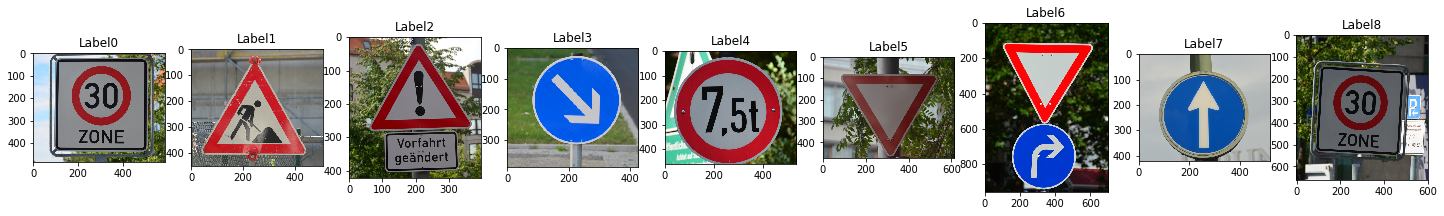

Resized new images as input for the NN


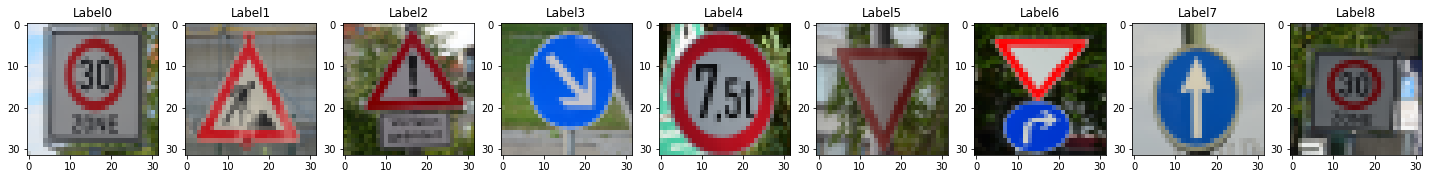

In [24]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

# The originator of the new images is Halteverbot123.de and they are downloaded from 
# http://www.halteverbot123.de/bilder-halteverbot-und-verkehrszeichen.html

import glob

new_files = glob.glob('new_images/**/*.png', recursive=True)

# read all new files and resize them as numpy array
print("New images in original size, The originator of these images is Halteverbot123.de")
new_images_orig = np.array([plt.imread(file) for file in new_files])
plot_images(new_images_orig, np.zeros(9))

print("Resized new images as input for the NN")
new_images = np.array([cv2.resize(image, (32,32), interpolation = cv2.INTER_AREA) for image in new_images_orig])
plot_images(new_images, np.zeros(9))      

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

Loaded 9 German traffic signs. I wanted to make sure these are real pictures and not some blue prints. This would be too easy. Most of them are in the dataset and should be labled correctly. Some of them look similar to ones from the original dataset but differ. There is one picture which contains two signs. After resizing them to 32x32x3 they loose a lot information and some of them are really hard to classify.

In [25]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
n_top = 5
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    new_dict = {x:new_images, keep_prob: 1}
    top5_prob = tf.nn.top_k(prob, n_top)

    top5 = sess.run(top5_prob, feed_dict=new_dict)

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

It's accuracy on all 9 images is 66%.

It's accuracy on the images which are also available in the original dataset is 100%. So it's performing quite good on the small set of images.


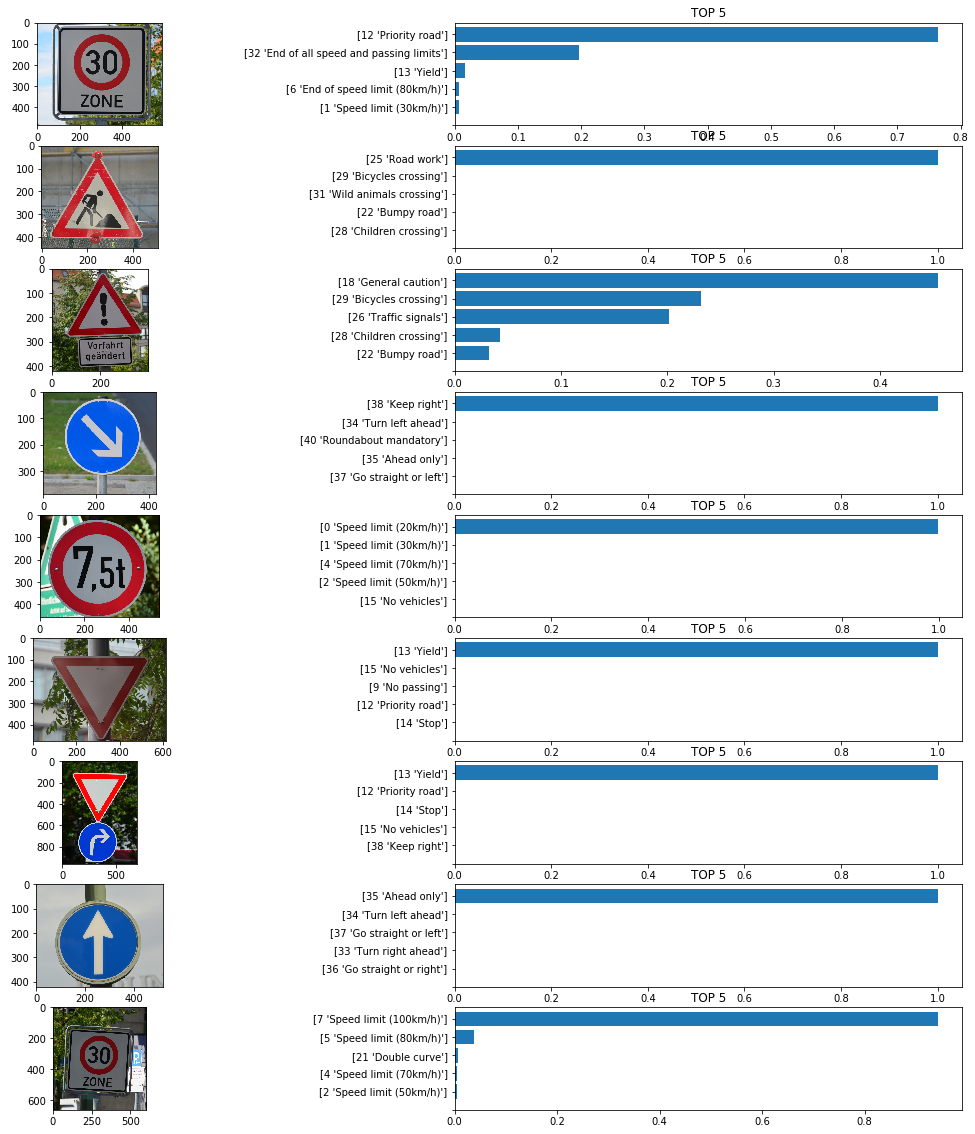

In [27]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
import pandas as pd
sign_names = pd.read_csv('signnames.csv', sep=',').values

plt.figure(figsize=(20, 20))
new_images_count = len(new_images_orig) 

for idx, image in enumerate(new_images_orig):
    plt.subplot(new_images_count, 2, idx*2+1)  
    plt.imshow(image)

    plt.subplot(new_images_count, 2, idx*2+2)  
    plt.barh(n_top-np.arange(n_top), top5.values[idx])
    sign_str = [sign_names[i] for i in top5.indices[idx]]
    sign_str.append('')
    plt.yticks(range(n_top+1), reversed(sign_str))
    plt.title('TOP 5')

plt.show()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

On the known signs the model is pretty sure about the classification. Just the "Road work sign" is a little bit low with ~45%.

I was a little bit surprised about the probabilities of the image containing two signs, "Yield" and "Turn right ahead". The model is pretty sure it's a yield sign and doesn't even consider the "Turn right ahead" sign in the TOP5. Also I would expect the "30 zone" sign would be classified as "Speed limit 30" signs but this is not the case and it classifies it even differently for the two images. This may show that this model does not cover all features.


> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.